<h1><i>Prediction of Avocado Prices using 2021 Hass Avocado Board (HAB) Aggregate Data

<i>My proposal mentioned that I would demonstrate by going to the store and seeing how much an avocado cost, but I failed to realize that this is aggregate data, and that the price in the dataset is an average. Therefore, that will not be my demonstration.

<h1>Import Libraries</h1>

In [1]:
import pandas as pd
import numpy as np

<h1>Import Dataset</h1>

<i>The dataset was created from another dataset: https://www.kaggle.com/datasets/timmate/avocado-prices-2020
NOTE: This uploader was kind enough to include a link to a Jupyter notebook to merge new HAB data into the dataset.
Notebook: https://colab.research.google.com/drive/1sXvsP4GgVx_sNsgG882a35OKqOdaam8f?usp=sharing

In [2]:
fileInput=pd.read_csv('avocado-updated-again-2022.csv')

<h1>Preprocessing</h1>

<h2>Drop subtotals and NaN

<i>I didn't know it, but removing all rows with NaN left only 2021 data in the dataset. That's a feature, not a bug.

In [3]:
    fileInput = fileInput.loc[fileInput['geography'] != 'Total U.S.']
    fileInput = fileInput.loc[fileInput['geography'] != 'Northeast']
    fileInput = fileInput.loc[fileInput['geography'] != 'Midsouth']
    fileInput = fileInput.loc[fileInput['geography'] != 'South Central']
    fileInput = fileInput.loc[fileInput['geography'] != 'Southeast']
    fileInput = fileInput.loc[fileInput['geography'] != 'West']
    data_df= fileInput.dropna().reset_index(drop=True)

<h2>Get months from date

<i>I found that only using the year gave horrible prediction accuracy. This was remediated by using month AND year.

In [4]:
    data_df['date'] = data_df['date'].astype('datetime64')
    data_df['month'] = data_df['date'].dt.month

<h2>Encode categorical data

In [5]:
#One Hot Encoding with Dummy Values
geo_types = tuple(data_df.geography)
type_types = tuple(data_df.type)
#year_types = tuple(data_df.year)
month_types = tuple(data_df.month)

geo_df = pd.DataFrame(geo_types, columns=['geography'])
type_df = pd.DataFrame(type_types, columns=['type'])
#year_df = pd.DataFrame(year_types, columns=['year'])
month_df = pd.DataFrame(month_types, columns=['month'])

dum_geo_df = pd.get_dummies(geo_df, columns=['geography'])
dum_type_df = pd.get_dummies(type_df, columns=['type'])
#dum_year_df = pd.get_dummies(year_df, columns=['year'])
dum_month_df = pd.get_dummies(month_df, columns=['month'])

data_df = data_df.join(dum_geo_df)
data_df = data_df.join(dum_type_df)
#data_df = data_df.join(dum_year_df)
data_df = data_df.join(dum_month_df)

<h2>Drop unneeded columns. Makes for easier analysis

<i> "year" wasn't needed since there was only one year, columns that were encoded were dropped, and irrelevant features were also dropped

In [6]:
data_df = data_df.drop(['year', 'month', 'date', 'type', 'geography', '4046', '4225', '4770', 'bulk_gtin', 'total_bags', 'small_bags', 'large_bags', 'xlarge_bags'], axis=1)

<h2>Show Shape

<i>Shown in (number of rows, number of columns)

In [7]:
data_df.shape
data_df.to_csv('avocado-updated-again-2022_ohe.csv')

<h2>Define x and y

In [8]:
x=data_df.drop(['average_price'], axis=1).values
y=data_df['average_price'].values

<h2>Split data for testing and training

In [9]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(x,y,test_size=0.3,random_state=0)

<h1>Training</h1>

<h2>Model 1: Linear Regression</h2>

In [10]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(trainX, trainY)

LinearRegression()

<h3>Linear Regression: Predict Prices</h3>

In [11]:
lr_predictY = lin_reg.predict(testX)

<h3> Linear Regression: Evaluation</h3>

In [12]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
def show_results(true, predicted, label=""):
    r2 = r2_score(true, predicted)
    mse = mean_squared_error(true, predicted)
    ev = explained_variance_score(true, predicted)
    print(f'{label}\nR^2:{r2}\nMean Squared Error:{mse}\nExplained Variance Score:{ev}')
show_results(testY, lr_predictY)


R^2:0.7881702146113535
Mean Squared Error:0.029454494303524002
Explained Variance Score:0.788186113475393


<h3> Linear Regression: Plot</h3>

Text(0.5, 1.0, 'Actual vs. Predicted')

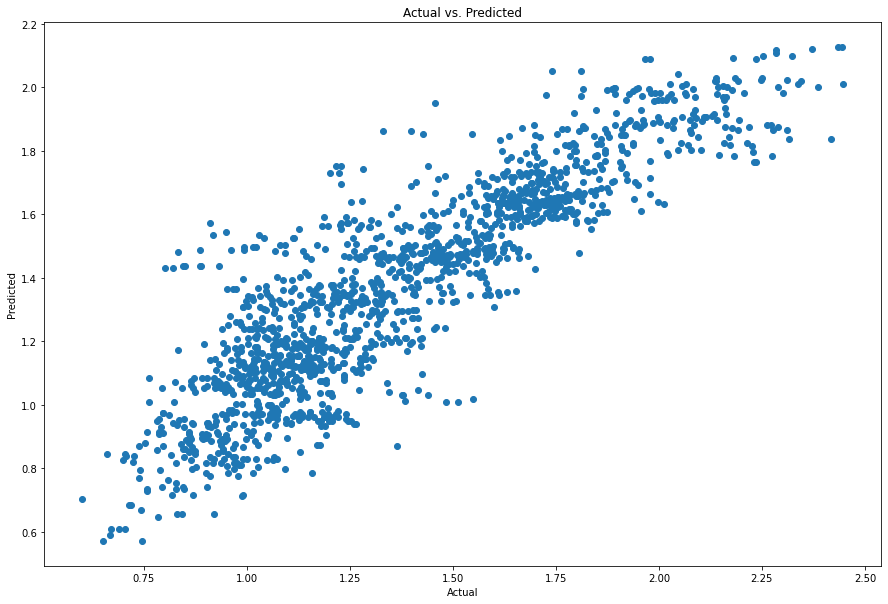

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.scatter(testY, lr_predictY)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')

<h2> Linear Regression: Findings

<i>As seen from the results, this model did poorly. It makes sense since most of the data is categorical, and linear regression isn't meant for categories.

<h2>Model 2: Gradient Boosted Regression</h2>

<i> Instead of finding a function to fit the data, let's use an ensemble of trees!

In [14]:
from sklearn.ensemble import GradientBoostingRegressor

greg = GradientBoostingRegressor()
greg.fit(trainX, trainY)

GradientBoostingRegressor()

<h3> Gradient Boosted Regression: Predict Prices </h3>

In [15]:
gr_predictY = greg.predict(testX)

<h3> Gradient Boosted Regression: Evaluation

In [16]:
show_results(testY, gr_predictY)


R^2:0.8279461927330416
Mean Squared Error:0.023923726669251775
Explained Variance Score:0.8279699450331854


<h3> Gradient Boosted Regression: Plot </h3>

Text(0.5, 1.0, 'Actual vs. Predicted')

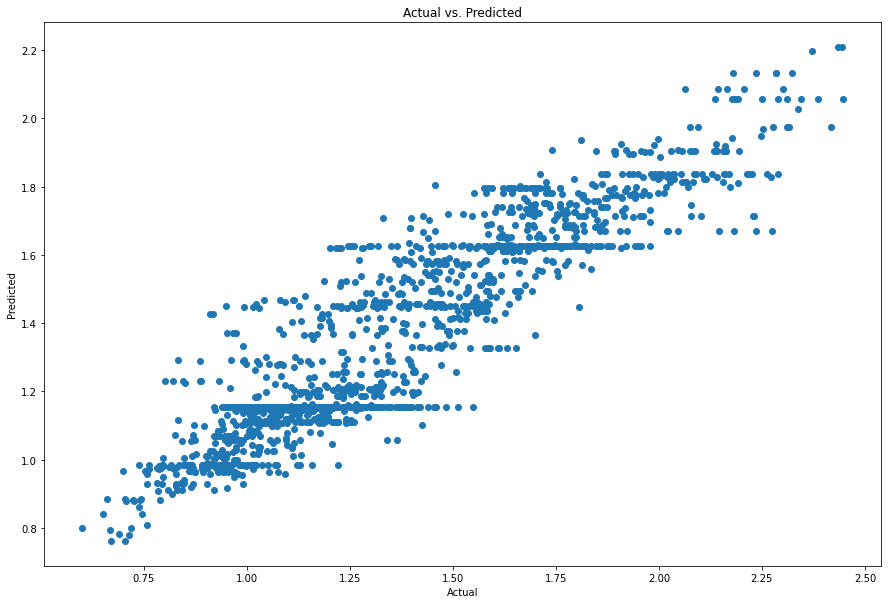

In [17]:
plt.figure(figsize=(15,10))
plt.scatter(testY, gr_predictY)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')

<h2>Gradient Boosted Regression: Findings

<i> This is better than Linear Regression, but still not a good model. Perhaps the data is too noisy and the tree overfit, and that makes sense since there is no correlation between each row of the dataset. Instead of having one tree and improving upon that tree, a random forest should be used as the dataset describes a plethora of areas in the US in various months.

<h2> Model 3: Random Forest</h2>

In [18]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor()
forest.fit(trainX, trainY)

RandomForestRegressor()

<h3>Random Forest: Predict Prices</h3>

In [19]:
forest_predictY = forest.predict(testX)

<h3>Random Forest: Evaluation</h3>

In [20]:
show_results(testY, forest_predictY)


R^2:0.9423333907548364
Mean Squared Error:0.008018422954066098
Explained Variance Score:0.9423409825138741


<h3>Random Forest: Plot</h3>

Text(0.5, 1.0, 'Actual vs. Predicted')

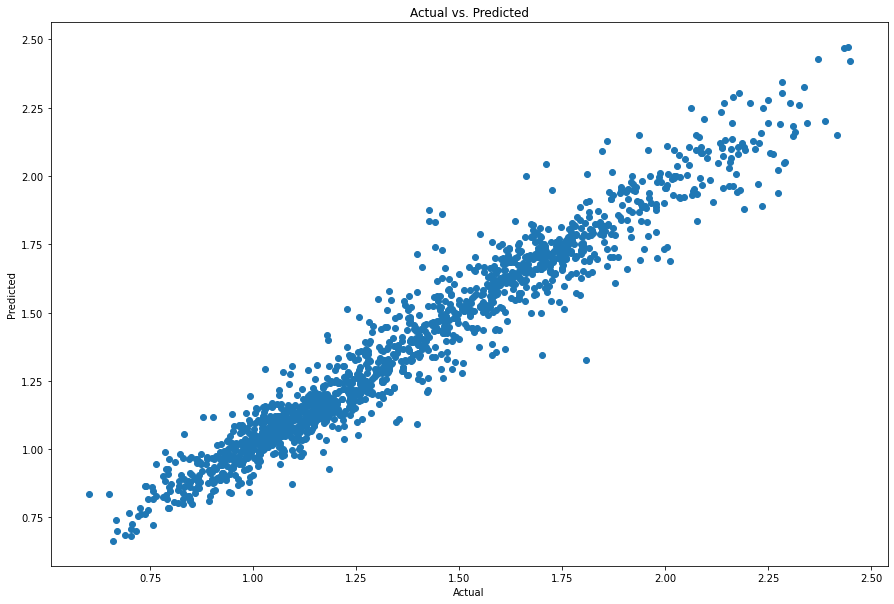

In [21]:
plt.figure(figsize=(15,10))
plt.scatter(testY, forest_predictY)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')

<h2>Random Forest: Findings

<i> Using a plethora of trees was the right choice! To reiterate, random forest was used since the data is too noisy for linear regression and GBR, and random forest can deal with the variety of areas, months, and the other data.
The goal stated in the proposal was an accuracy of 95%, but 94% is acceptable!

<i>The variance described in the previous models has been reduced thanks to how random forest works. Because of that, more accurate price averages can be predicted!

<h1>Demo

<h2>Consider the following datapoint. Describes Dallas/Ft Worth in June 2021 with conventional avocadoes.

In [24]:
demo_data = [[0.857971589,1559951.09,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0]]
#True avg price is $0.85
demoTrueY = [[0.857971589]]
demoX = [[1559951.09,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0]]
demoY = [[0.857971589]]
demo_predictY = forest.predict(demoX)
print(demo_predictY)

[0.83751484]


<i> Run the cell above, and see the the predicted average price is within a TINY margin! It may be slightly different due to the nature of the Random Forest model using random data per tree, but at the time of typing this, the prediction was $0.83751484, which is 2 cents off of the true value! Recalling the explained variance score and the MSE from the Random Tree training, this prediction is within error (.83/.85 = 0.97)